# Shopping Apps, Rating for Google Play Store and Apple AppStore Users

## Introduction

Users download apps for various purposes. Given that there is a rise in the usage of online shopping due to the Covid-19 pandemic, improvement of shopping experience has become more important then before. With that in mind, what are the important features we have to look out for to improve a shopping app?

More specifically, the questions to be answered:

- How do the app ratings differ across different shopping apps?
- Is there any specific group of users we can look out for to improve the app?
- Are there any specific improvement we can work on to further improve user experience of the app?

To explore and answer the above questions, we will scrap reviews from Google Play Store and Apple AppStore and conduct analysis and modelling.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import matthews_corrcoef, confusion_matrix, roc_auc_score, plot_roc_curve, plot_confusion_matrix
from sklearn.metrics import classification_report, roc_curve, cohen_kappa_score

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer                    
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Embedding, Conv1D, GlobalMaxPooling1D, Flatten, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import reduce_sum, square, py_function, double
from tensorflow.keras.metrics import Accuracy, CategoricalAccuracy, CosineSimilarity
from tensorflow.keras.regularizers import l1_l2, l2, l1
from tensorflow.math import confusion_matrix
from tensorflow_addons.metrics import CohenKappa, MatthewsCorrelationCoefficient, F1Score, MultiLabelConfusionMatrix
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from tensorflow import concat
from tensorflow.keras import Model
from gensim.models import KeyedVectors

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Datasets/reviews_Model.csv')

In [ ]:
df.head()

,rating,date,app,store,review,clean_content,adj,noun,verb,emoji,neg_score,neu_score,pos_score,compound_score,language,month,dayofweek,hour,minute,text_len,word_count,category
0,5,2020-09-16 20:26:28,shoppee,google,Orders mostly came early and products are good.,order come early product good,good,order product,come,NaN,0.0,0.707,0.293,0.4404,en,9,3,20,26,47,8,Delivery
1,4,2020-09-16 20:13:46,shoppee,google,Good and convenient,good convenient,good convenient,NaN,NaN,NaN,0.0,0.408,0.592,0.4404,en,9,3,20,13,19,3,Convenient App
2,4,2020-09-16 20:11:18,shoppee,google,My first purchase experience...Happy with purc...,purchase experience happy purchase thks,first happy,purchase experience purchase,NaN,NaN,0.0,0.714,0.286,0.3400,en,9,3,20,11,57,7,Consumer Satisfaction
3,5,2020-09-16 20:08:54,shoppee,google,A lot of items at a very good deal.,lot item good deal,good,lot item deal,NaN,NaN,0.0,0.715,0.285,0.4927,en,9,3,20,8,35,9,Variety & Price
4,5,2020-09-16 19:37:21,shoppee,google,Delivery is fast,delivery fast,fast,delivery,NaN,NaN,0.0,1.000,0.000,0.0000,en,9,3,19,37,16,3,Delivery


In [ ]:
#list comprehension for target variable
df = df[df['rating'] <= 3]

In [ ]:
df['category'].value_counts(normalize = True)

Account Issues            0.179483
App Issues                0.169551
User Interface            0.122759
Delivery Issues           0.122371
Refund                    0.099247
Poor Customer Service     0.093583
Product Issue             0.061845
Payment Issue             0.055094
Poor Seller Feedback      0.054163
Product Listing Issues    0.041903
Name: category, dtype: float64

In [ ]:
#Checking null values
df.isna().sum()[df.isna().sum() > 0]

adj       2872
noun       640
verb      1159
emoji    12267
dtype: int64

In [ ]:
## Removing null values
df= df[df['clean_content'].notna()]
df.reset_index(drop = True, inplace = True)
print(f'Null values left in df: {df.clean_content.isna().sum()}')
print(f'Number of rows left: {df.shape[0]}')

Null values left in df: 0
Number of rows left: 12887


## Train Test Split Data

In [ ]:
X = df['clean_content']
y = df['category']

lb = LabelEncoder()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 42,
                                                    stratify = y)

In [ ]:
print(f'X_train rows: {X_train.shape[0]}, X_test rows: {X_test.shape[0]}')
print(f'y_train rows: {y_train.shape[0]}, y_test rows: {y_test.shape[0]}')

X_train rows: 10309, X_test rows: 2578
y_train rows: 10309, y_test rows: 2578


## Convolutional Neural Network

## Loading Word2Vec Model

In [ ]:
word2vec_path = '/content/drive/My Drive/Colab Notebooks/Datasets/GoogleNews-vectors-negative300.bin'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


### Tokenize Features

In [ ]:
tokenizer = Tokenizer(num_words=None, filters='!"#$%&()*+,-./:;<=>?...', lower=True, split=' ', char_level=False, oov_token= None)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
# Adding 1 because of  reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 300

y_train_label = lb.fit_transform(y_train)
y_test_label = lb.transform(y_test)

y_train_dummy = to_categorical(y_train_label)
y_test_dummy = to_categorical(y_test_label)

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

embedding_dim = 300

In [ ]:
train_embedding_weights = np.zeros((vocab_size, embedding_dim))

for word,index in tokenizer.word_index.items():
  train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(embedding_dim)

print(train_embedding_weights.shape)

(9589, 300)


### Adding Sequence for Network

In [ ]:
def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index):
 
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=False)
    
    sequence_input = Input(shape=(max_sequence_length,), dtype='float64')
    embedded_sequences = embedding_layer(sequence_input)
    convs = []
    filter_sizes = [2, 3, 4, 5, 6]
    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=200, 
                        kernel_size=filter_size, 
                        activation='relu')(embedded_sequences)
        l_pool = GlobalMaxPooling1D()(l_conv)
        convs.append(l_pool)
    l_merge = concat(convs, axis=1)
    x = Dropout(0.5)(l_merge)  
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    preds = Dense(labels_index, activation='softmax')(x)
    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=[CategoricalAccuracy(name= 'acc')])
    model.summary()
    return model

### Network Summary

In [ ]:
model = ConvNet(train_embedding_weights, 
                maxlen, 
                vocab_size, 
                embedding_dim, 
                10)

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 300, 300)     2876700     input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 299, 200)     120200      embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 299, 200)     120200      embedding_1[0][0]                
_______________________________________________________________________________________

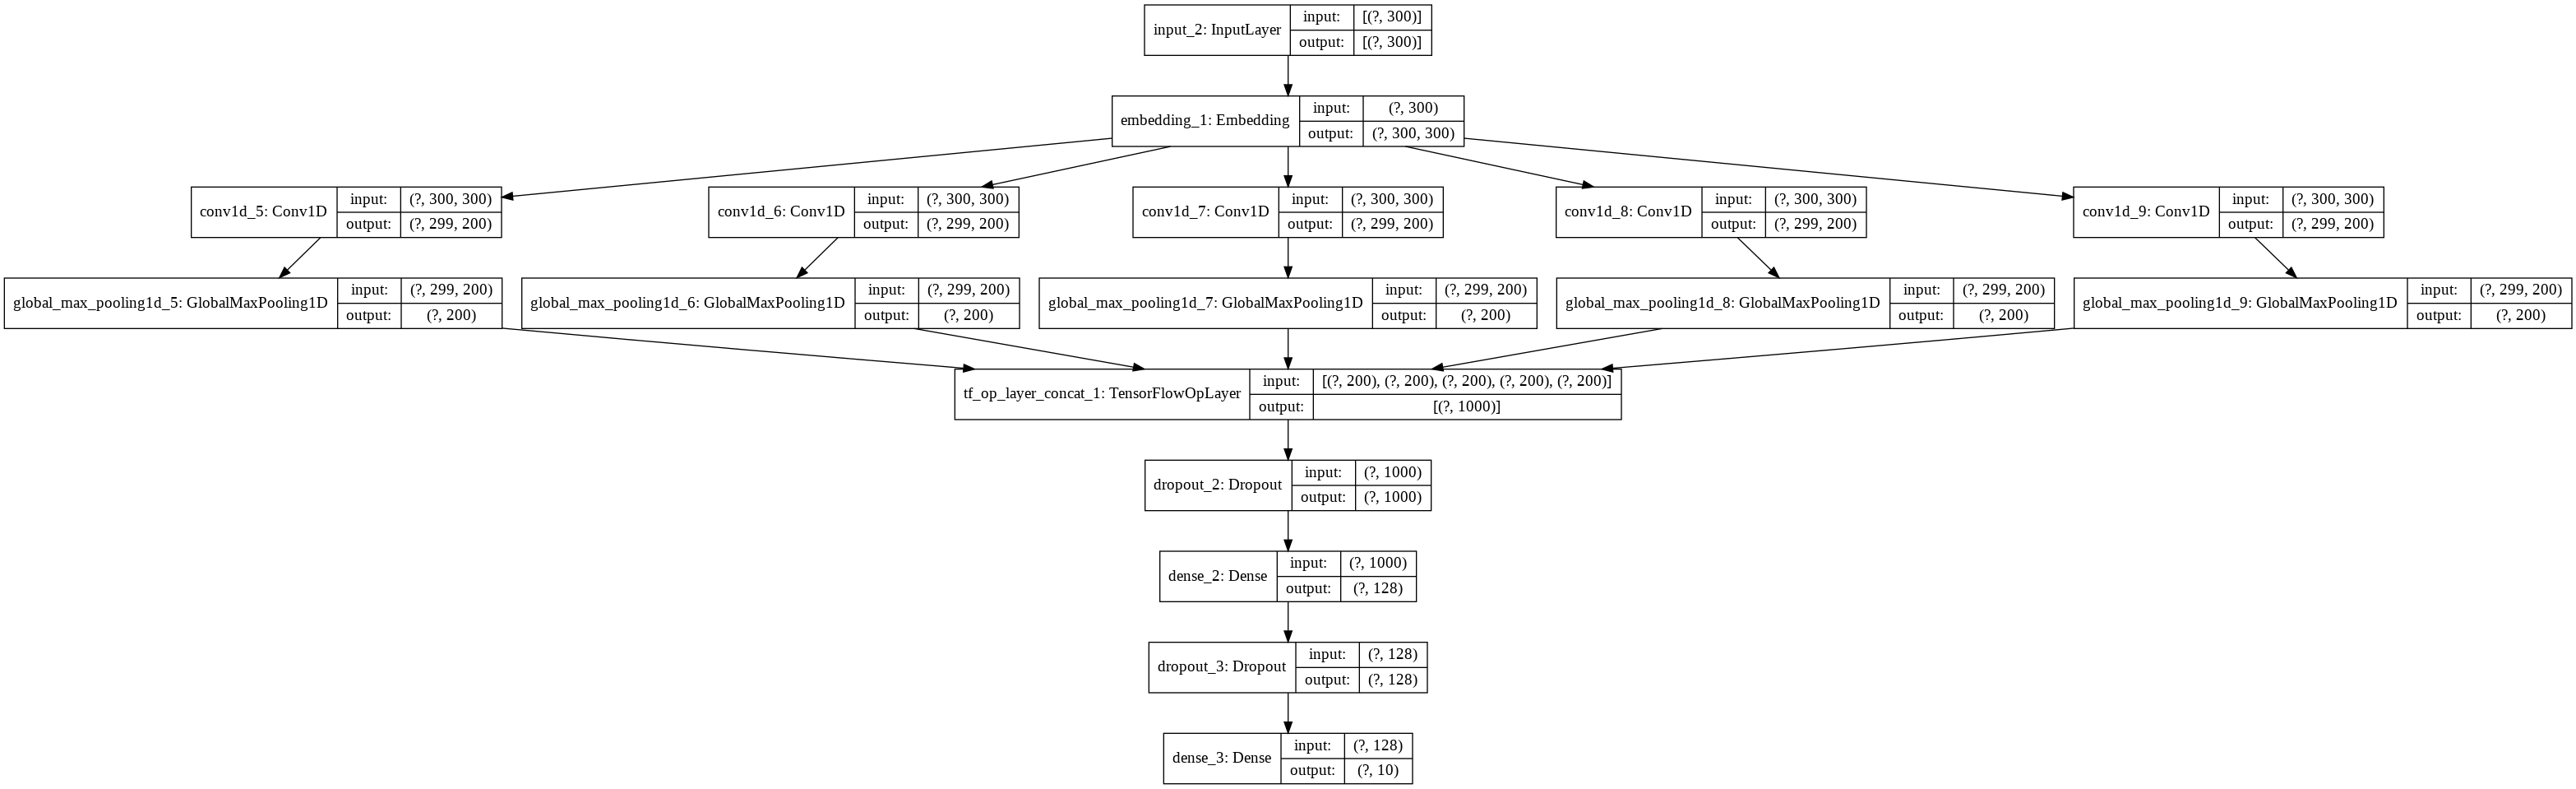

In [ ]:
plot_model(model, "my_first_model.png", show_shapes = True)

### Training Neural Network

In [ ]:
earlystop = EarlyStopping(monitor='val_acc', patience=10, min_delta=0.0001, 
                          mode = 'max')

In [ ]:
class_weights = class_weight.compute_class_weight('balanced',
                                            np.unique(y_train),
                                            y_train)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.5572432432432433,
 1: 0.5897597254004576,
 2: 0.816877971473851,
 3: 1.8149647887323943,
 4: 1.0682901554404145,
 5: 1.8474910394265234,
 6: 1.6158307210031349,
 7: 2.3863425925925927,
 8: 1.00772238514174,
 9: 0.8149407114624506}

In [ ]:
num_epochs = 100
hist = model.fit(X_train, 
                 y_train_dummy, 
                 epochs=num_epochs, 
                 validation_data = (X_test,y_test_dummy) , 
                 shuffle=True,
                 callbacks = earlystop)

Epoch 1/100
323/323 [==============================] - 6s 17ms/step - loss: 1.6492 - acc: 0.4446 - val_loss: 1.2110 - val_acc: 0.6226
Epoch 2/100
323/323 [==============================] - 5s 17ms/step - loss: 1.2273 - acc: 0.5870 - val_loss: 1.0919 - val_acc: 0.6420
Epoch 3/100
323/323 [==============================] - 6s 17ms/step - loss: 1.0498 - acc: 0.6485 - val_loss: 1.0521 - val_acc: 0.6571
Epoch 4/100
323/323 [==============================] - 5s 17ms/step - loss: 0.9195 - acc: 0.6880 - val_loss: 1.0275 - val_acc: 0.6587
Epoch 5/100
323/323 [==============================] - 5s 17ms/step - loss: 0.8011 - acc: 0.7245 - val_loss: 0.9986 - val_acc: 0.6680
Epoch 6/100
323/323 [==============================] - 5s 17ms/step - loss: 0.6880 - acc: 0.7734 - val_loss: 0.9870 - val_acc: 0.6730
Epoch 7/100
323/323 [==============================] - 5s 17ms/step - loss: 0.6058 - acc: 0.7926 - val_loss: 1.0527 - val_acc: 0.6691
Epoch 8/100
323/323 [==============================] - 5s 17ms

### Accuracy of Network

In [ ]:
predictions = np.argmax(hist.model.predict(X_test), axis=-1)
predictions

array([1, 9, 8, ..., 1, 8, 9])

In [ ]:
   # evaluate
loss, acc = hist.model.evaluate(X_test, y_test_dummy, verbose=0)
print('Test Accuracy: %f' % (acc*100))
print(f'MCC Score: {matthews_corrcoef(y_test_label, predictions)}')
print(f'Kappa Score: {cohen_kappa_score(y_test_label, predictions)}')

Test Accuracy: 67.571759
MCC Score: 0.6301261191635481
Kappa Score: 0.6297819016036369


### Heatmap of Neural Network

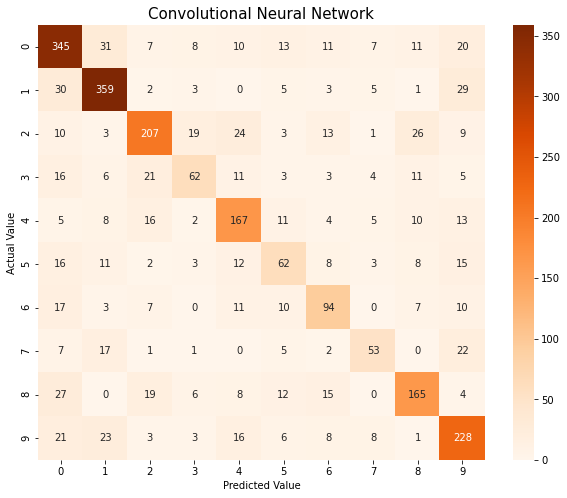

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.title('Convolutional Neural Network', fontdict = {'fontsize': 15})
ax = sns.heatmap(confusion_matrix(y_test_label, predictions), annot=True, fmt="d", cmap='Oranges')
ax.set_ylabel('Actual Value')
ax.set_xlabel('Predicted Value');

### Plotting ROC AUC Curve

### Check Misclassified Posts

In [ ]:
lb.inverse_transform(predictions)

array(['App Issues', 'User Interface', 'Refund', ..., 'App Issues',
       'Refund', 'User Interface'], dtype=object)

In [ ]:
# Create DataFrame with column for predicted values.
results = pd.DataFrame(lb.inverse_transform(predictions), columns=['predicted'], index = y_test.index)

# Create column for observed values.
results['actual'] = y_test
results['review'] = df['review']
results['clean_content'] = df['clean_content']

# Find all indices where predicted and true results 
# aren't the same, then save in an array.
ms_class = results[results['predicted']!= results['actual']]
ms_class.head(10)

,predicted,actual,review,clean_content
5790,User Interface,Poor Seller Feedback,"The app is nothing special, it does not really...",app special tell item sake recomendation okay ...
9630,Refund,Delivery Issues,I love asos...but I think it's wrong that when...,love think wrong wrong item send happen time p...
8941,Account Issues,Payment Issue,Packages don't arive half of the time and the ...,package arive half time app kind confusing nav...
2968,App Issues,Product Issue,"Many fake seller, it should have reporting but...",fake seller reporting button check fake seller...
9990,Payment Issue,Delivery Issues,"Had the worst experience with Asos, not only d...",bad experience try help simple mistake option ...
1122,Poor Seller Feedback,Product Issue,Money grabbing policy will make this app usele...,money grab policy app useless soon seller caus...
10014,Payment Issue,Refund,I ordered two pair of shoes and a t-shirt.No c...,order pair shoe t shirt charge import mention ...
9388,User Interface,Poor Customer Service,"Search function is rubbish, as is range and la...",search function rubbish range lack reputable s...
11401,Delivery Issues,Payment Issue,Always takes so long to get stuff,take long stuff
5395,Account Issues,Poor Seller Feedback,So so difficult to fill in address and postal ...,difficult fill address postal code impossible ...


In [ ]:
# save model and architecture to single file
model.save('/content/drive/My Drive/Colab Notebooks/2.model.h5')
print('Saved model to disk')

Saved model to disk


In [ ]:
from keras.models import load_model
 
# load model
model = load_model('/content/drive/My Drive/Colab Notebooks/2.model.h5')
# summarize model.
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 300, 300)     2876700     input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 299, 200)     120200      embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 299, 200)     120200      embedding_1[0][0]                
_______________________________________________________________________________________

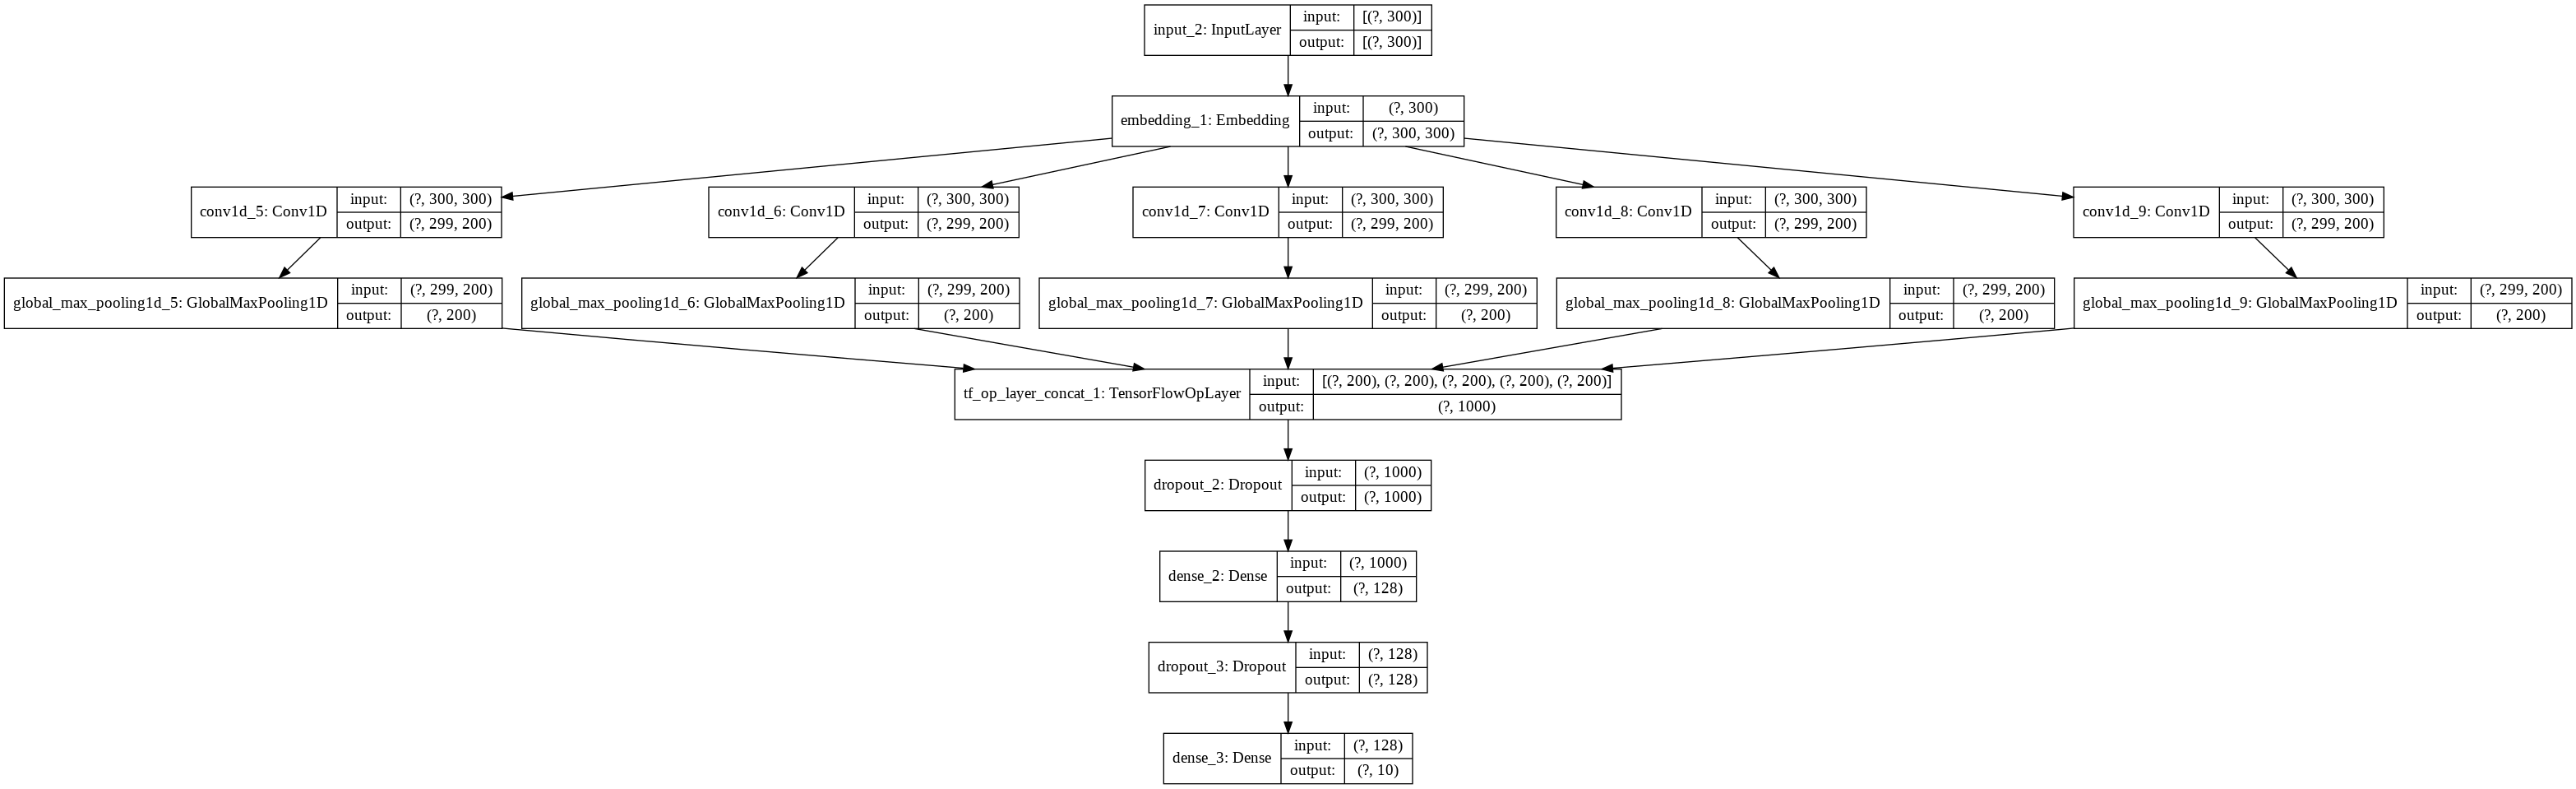

In [ ]:
plot_model(model, "my_first_model.png", show_shapes = True)